In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from sdebridge.diffusion_bridge import DiffusionBridge
from sdebridge.sde import fourier_gaussian_kernel_sde, reverse
from sdebridge.utils import score_fn
from sdebridge.data_processing import sample_ellipse, butterfly1_pts

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

In [3]:
T=1.
N=50
dim=2
num_bases = 8
alpha = 0.1
sigma=0.1
n_grid = 64 
grid_range = (-1.5, 1.5)
n_samples = 100


# {
#         'init_S': S0,
#         'n_bases': n_bases,
#         'n_grid': 64,
#         'grid_range': [-1.5, 1.5],
#         'alpha': 1.0,
#         'sigma': 0.1,
#         'T': 1.0,
#         'N': 50,
#         'dim': 2
#     }

In [4]:
    def fourier_coefficients(array, num_bases):
        """Array of shape [..., pts, dim]
        Returns array of shape [..., :2*num_bases, dim]"""

        complex_coefficients = jnp.fft.rfft(array, norm="forward", axis=-2)[..., :num_bases, :]
        coeffs = jnp.stack([complex_coefficients.real, complex_coefficients.imag], axis=0)
        coeffs = coeffs.reshape(*complex_coefficients.shape[:-2], -1, complex_coefficients.shape[-1])
        return coeffs

    def inverse_fourier(coefficients, num_pts):
        """Array of shape [..., 2*num_bases, dim]
        Returns array of shape [..., num_pts, dim]"""
        assert coefficients.shape[-2] % 2 == 0
        num_bases = int(coefficients.shape[-2] / 2)
        coeffs_real = coefficients[..., :num_bases, :]
        coeffs_im = coefficients[..., num_bases:, :]
        complex_coefficients = coeffs_real + 1j * coeffs_im
        return jnp.fft.irfft(complex_coefficients, norm="forward", n=num_pts, axis=-2)

(120, 2)
(16, 2)


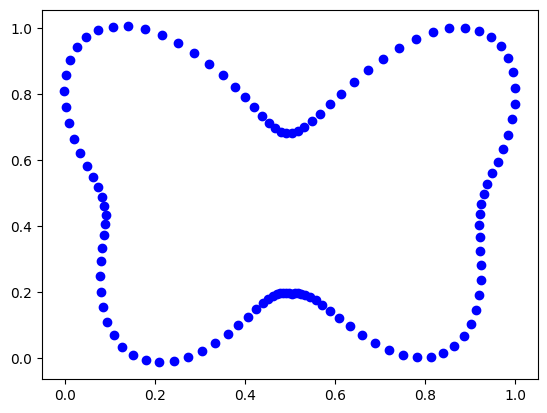

In [5]:
butterfly = jnp.array(butterfly1_pts())[:, ::1861][:, ::1].T
butterfly_coeffs = fourier_coefficients(butterfly, num_bases)
butterfly_recon = inverse_fourier(butterfly_coeffs, 120)

print(butterfly_recon.shape)
print(butterfly_coeffs.shape)
plt.scatter(butterfly_recon[:, 0], butterfly_recon[:, 1], c="b")

In [6]:
# ellipse coefficients
ellipse_pts = sample_ellipse(200, scale=0.5, shifts=jnp.asarray([0.5, 0.5]))
ellipse_coeffs = fourier_coefficients(ellipse_pts, num_bases)

In [8]:
sde = fourier_gaussian_kernel_sde(T, N, dim, num_bases, alpha, sigma, n_grid, grid_range, n_samples)
key = jax.random.PRNGKey(2)

forward_trajs = sde.simulate_trajectories(ellipse_coeffs, 2, key)

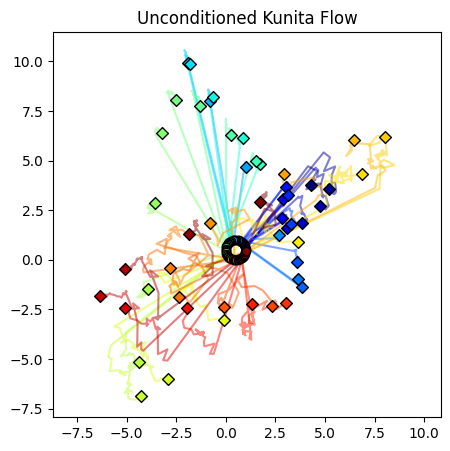

In [9]:
from sdebridge.plotting import plot_single_trajectory

forward_traj_coeffs = forward_trajs[0]
forward_traj = inverse_fourier(forward_traj_coeffs, 50)
traj = forward_traj.reshape((N, -1))
plot_single_trajectory(traj, "Unconditioned Kunita Flow")